El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos
### Carga y exploración inicial de los datos

En este paso, cargaremos el conjunto de datos y realizaremos una exploración inicial para identificar posibles problemas, como valores faltantes o tipos de datos incorrectos. Verificaremos las primeras filas del conjunto de datos, la cantidad de valores faltantes y los tipos de datos de cada columna.

In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import time
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import torch
import cupy as cp

In [3]:
print(torch.cuda.is_available())
print(cp.__version__)

True
13.3.0


In [4]:
# Configuración para usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Cargar los datos
data = pd.read_csv('./data/car_data.csv')

# Ver las primeras filas del dataset para inspección inicial
display(data.head())

# Revisar información general sobre el dataset
data.info()

# Verificar valores faltantes por columna
missing_values = data.isnull().sum()
display(missing_values[missing_values > 0])


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
NotRepaired    71154
dtype: int64

### Preprocesamiento de los datos

En este paso, vamos a realizar el preprocesamiento de los datos para manejar los valores faltantes y convertir las columnas con tipos de datos incorrectos a los tipos adecuados. También haremos una revisión de las columnas que no sean relevantes para el análisis del precio del vehículo y las eliminaremos si es necesario.


In [6]:
# Eliminar la columna 'NumberOfPictures' ya que tiene un solo valor (0) para todas las entradas
data = data.drop(columns=['NumberOfPictures'])

# Convertir las columnas de fecha a tipo datetime para un manejo más eficiente
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%d/%m/%Y %H:%M')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%d/%m/%Y %H:%M')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%d/%m/%Y %H:%M')

# Para las columnas con valores faltantes:
# 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired': Imputamos con "desconocido"
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')


# Revisar las primeras filas después del preprocesamiento
display(data.head())

# Verificar que no queden valores nulos
print(data.isnull().sum())


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:00


DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64


## Verificación de Outliers y Análisis Exploratorio

Vamos a analizar la distribución de algunas variables clave como `Price`, `Power` y `RegistrationYear`. Nos aseguraremos de que no haya valores fuera de rango y, si encontramos outliers, tomaremos decisiones sobre cómo manejarlos. También verificaremos si las variables tienen distribuciones razonables para los datos de vehículos usados.


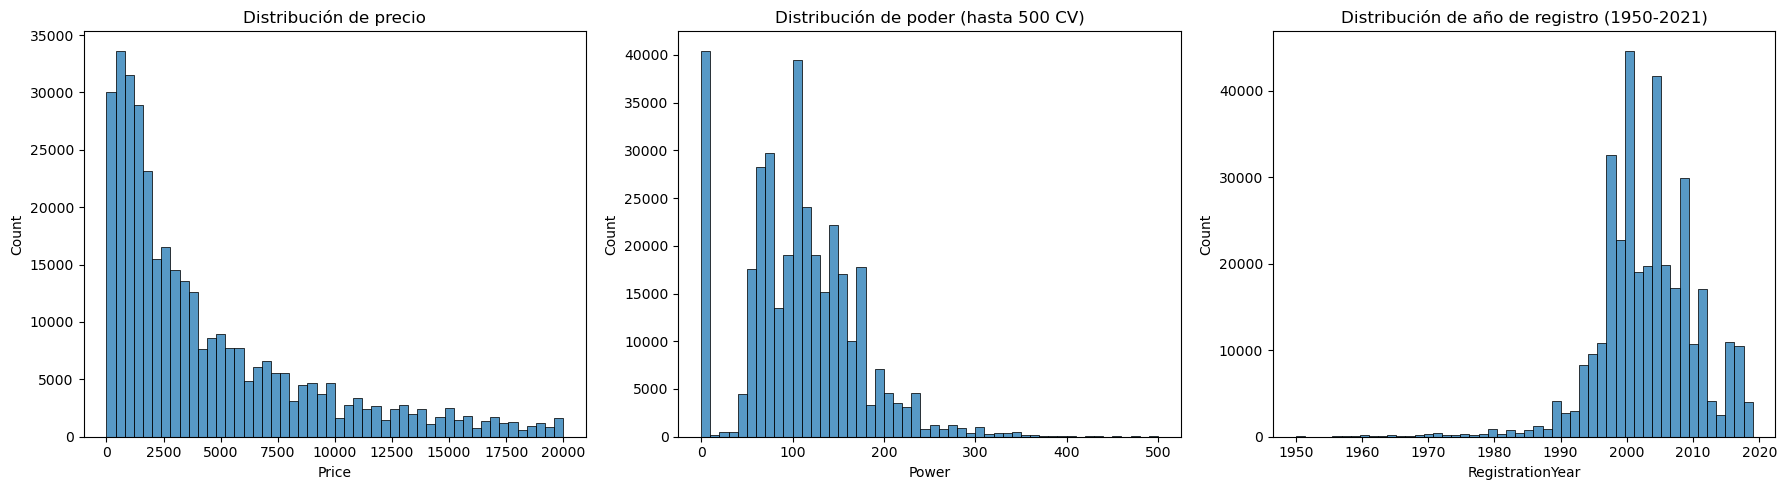

In [7]:
# Definir límites razonables para las variables
max_power = 500  # Establecer un máximo realista para la potencia (500 CV)
min_year = 1950  # Establecer un año mínimo realista de registro
max_year = 2021  # Establecer un año máximo realista de registro

# Graficar nuevamente con límites ajustados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfica de distribución de Price (sin cambios)
sns.histplot(data['Price'], bins=50, ax=axes[0])
axes[0].set_title('Distribución de precio')

# Gráfica de Power ajustando el límite
sns.histplot(data[data['Power'] <= max_power]['Power'], bins=50, ax=axes[1])
axes[1].set_title('Distribución de poder (hasta 500 CV)')

# Gráfica de RegistrationYear ajustando los límites
sns.histplot(data[(data['RegistrationYear'] >= min_year) & (data['RegistrationYear'] <= max_year)]['RegistrationYear'], bins=50, ax=axes[2])
axes[2].set_title('Distribución de año de registro (1950-2021)')

plt.tight_layout()
plt.show()

### Eliminación de filas con `Power = 0`
Procedemos a eliminar las filas donde el valor de `Power` (caballos de fuerza) es igual a 0, ya que es imposible que un automóvil tenga 0 caballos de fuerza. Esta limpieza permitirá que nuestros datos sean más precisos y representativos.


Se han eliminado 40225 filas con Power = 0


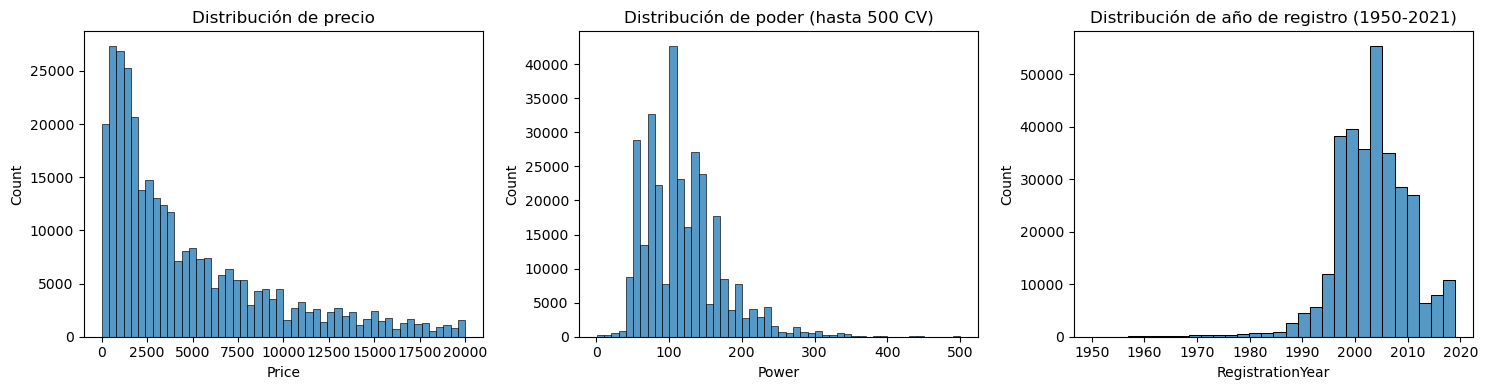

In [8]:
# Eliminar las filas donde Power es igual a 0
data_clean = data[data['Power'] != 0]

# Comprobar el número de filas eliminadas
eliminated_rows = len(data) - len(data_clean)
print(f"Se han eliminado {eliminated_rows} filas con Power = 0")

# Volver a generar las distribuciones para asegurarnos de que los datos están limpios
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

data_clean[['Price', 'Power', 'RegistrationYear']].describe().T

# Distribución de Price
sns.histplot(data_clean['Price'], bins=50, ax=axes[0])
axes[0].set_title("Distribución de precio")

# Distribución de Power (hasta 500 CV)
sns.histplot(data_clean[data_clean['Power'] <= 500]['Power'], bins=50, ax=axes[1])
axes[1].set_title("Distribución de poder (hasta 500 CV)")

# Distribución de RegistrationYear (1950-2021)
sns.histplot(data_clean[(data_clean['RegistrationYear'] >= 1950) & (data_clean['RegistrationYear'] <= 2021)]['RegistrationYear'], bins=30, ax=axes[2])
axes[2].set_title("Distribución de año de registro (1950-2021)")

plt.tight_layout()
plt.show()


Tamaño del conjunto de datos original: (354369, 15)
Tamaño del conjunto de datos después de eliminar outliers: (348831, 15)


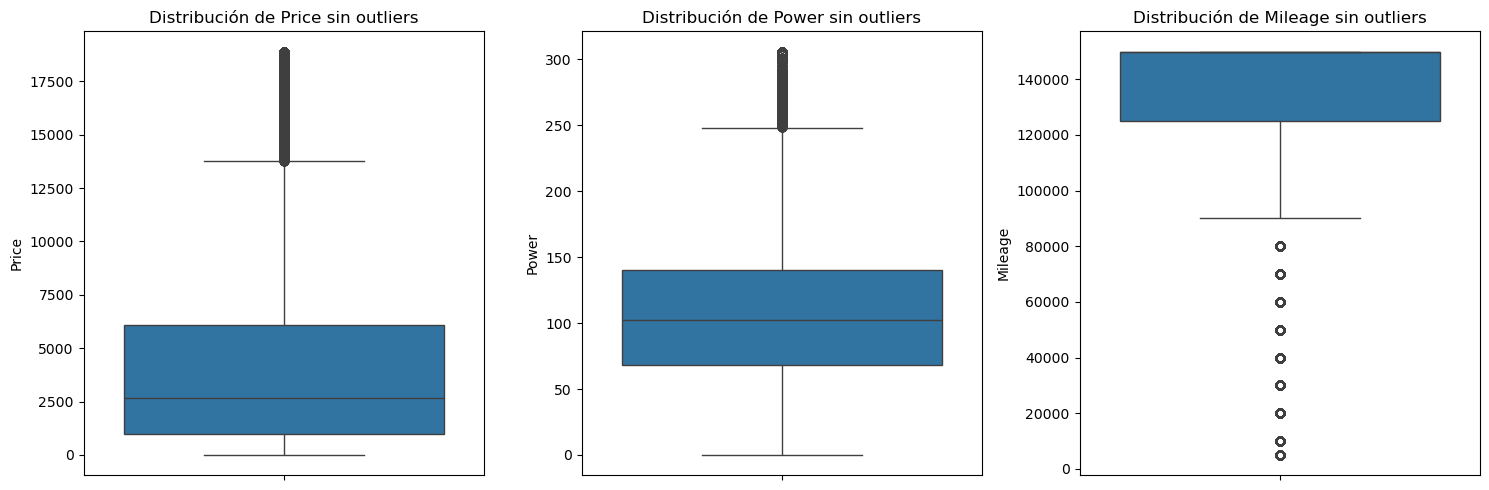

In [9]:
# Definir los umbrales para eliminar valores atípicos
price_upper_threshold = data_clean['Price'].quantile(0.99)
power_upper_threshold = data_clean['Power'].quantile(0.99)
mileage_lower_threshold = data_clean['Mileage'].quantile(0.01)

# Filtrar los datos para eliminar outliers
data_clean = data[
    (data['Price'] <= price_upper_threshold) & 
    (data['Power'] <= power_upper_threshold) & 
    (data['Mileage'] >= mileage_lower_threshold)
]

# Verificar la reducción de datos después de la eliminación de outliers
print(f"Tamaño del conjunto de datos original: {data.shape}")
print(f"Tamaño del conjunto de datos después de eliminar outliers: {data_clean.shape}")

# Mostrar las distribuciones nuevamente
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=data_clean, y='Price', ax=axes[0])
axes[0].set_title('Distribución de Price sin outliers')

sns.boxplot(data=data_clean, y='Power', ax=axes[1])
axes[1].set_title('Distribución de Power sin outliers')

sns.boxplot(data=data_clean, y='Mileage', ax=axes[2])
axes[2].set_title('Distribución de Mileage sin outliers')

plt.tight_layout()
plt.show()


## Entrenamiento del modelo 


Vamos a dividir el conjunto de datos en características y la variable objetivo (Price), luego en datos de entrenamiento y prueba. Además, prepararemos los datos para entrenar varios modelos de machine learning.

1. Dividir el conjunto de datos en variables características (X) y variable objetivo (y).
2. Codificar las variables categóricas utilizando One-Hot Encoding.
3. Dividir los datos en conjuntos de entrenamiento y prueba.
4. Normalizar las características numéricas.



#### Funciones para entrenamiento y evaluación de modelos
Vamos a definir una función que evalúe el desempeño de los modelos en términos de RMSE, tiempo de entrenamiento y tiempo de predicción.


In [10]:
# Función para calcular el RMSE
def rmse(y_true, y_pred):
    return np.sqrt(root_mean_squared_error(y_true, y_pred))

# Función para entrenar y evaluar el modelo
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time_train = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time_train

    start_time_predict = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    prediction_time = time.time() - start_time_predict
    
    rmse_train = rmse(y_train, y_pred_train)
    rmse_test = rmse(y_test, y_pred_test)
    
    return {
        'train_rmse': rmse_train,
        'test_rmse': rmse_test,
        'training_time': training_time,
        'prediction_time': prediction_time
    }

### División de los datos en entrenamiento y prueba
Dividimos los datos reducidos en conjuntos de entrenamiento y prueba.


In [11]:
# Paso 1: Seleccionar las características y la variable objetivo, eliminando las columnas de fechas
X = data_clean.drop(columns=['Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'])
y = data_clean['Price']

# Paso 2: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Paso 3: Codificar variables categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Paso 4: Normalizar características numéricas
scaler = StandardScaler()

numeric_columns = ['RegistrationYear', 'Power', 'Mileage']
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])   

# Concatenar los datos codificados y normalizados
X_train_final = np.concatenate([X_train_scaled, X_train_encoded], axis=1)
X_test_final = np.concatenate([X_test_scaled, X_test_encoded], axis=1)

# Cambiar el tipo de los datos a un DataFrame con las mismas columnas originales
column_names = encoder.get_feature_names_out(categorical_columns).tolist() + numeric_columns
X_train_final = pd.DataFrame(X_train_final, columns=column_names)
X_test_final = pd.DataFrame(X_test_final, columns=column_names)


# Verificar las formas de los datos finales
print("Tamaño de X_train_final:", X_train_final.shape)
print("Tamaño de X_test_final:", X_test_final.shape)

Tamaño de X_train_final: (174415, 317)
Tamaño de X_test_final: (174416, 317)


### Modelo 1: Regresión Lineal
Vamos a entrenar un modelo de regresión lineal como prueba de cordura y evaluaremos su desempeño.


In [12]:
# Crear el modelo de regresión lineal
linear_model = LinearRegression()

# Evaluar el modelo
linear_results = evaluate_model(linear_model, X_train_final, y_train, X_test_final, y_test)

# Mostrar los resultados
print("Resultados de la Regresión Lineal:")
print(linear_results)

Resultados de la Regresión Lineal:
{'train_rmse': 53.45780131644442, 'test_rmse': 53.45264788163231, 'training_time': 1.7829651832580566, 'prediction_time': 0.16889095306396484}


### Modelo 2: Random Forest
Entrenaremos un modelo de Random Forest para ver si mejora el desempeño en comparación con la regresión lineal.

In [15]:
# Definir los hiperparámetros que queremos ajustar con menos combinaciones
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Crear el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Usar RandomizedSearchCV en lugar de GridSearchCV
random_search_rf = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist_rf, 
    n_iter=2,  # Probará 2 combinaciones aleatorias de hiperparámetros
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)

# Ajustar el modelo utilizando RandomizedSearchCV
random_search_rf.fit(X_train_final, y_train)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros para Random Forest:", random_search_rf.best_params_)

# Evaluar el modelo ajustado
rf_best = random_search_rf.best_estimator_
rf_results_best = evaluate_model(rf_best, X_train_final, y_train, X_test_final, y_test)

print("Resultados del Random Forest Ajustado:")
print(rf_results_best)

Mejores hiperparámetros para Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}
Resultados del Random Forest Ajustado:
{'train_rmse': 32.267835771043586, 'test_rmse': 41.03236069615627, 'training_time': 390.84693670272827, 'prediction_time': 12.535650968551636}


### Modelo 3: LightGBM
Ahora, probaremos un modelo de LightGBM, que suele ser muy eficiente y tiene un buen desempeño en grandes conjuntos de datos.

In [16]:
param_grid_lgb = {
    'n_estimators': [100],  # Reducir las iteraciones a 100
    'learning_rate': [0.1, 0.05, 0.3],  # Usar tasas de aprendizaje más altas para converger más rápido
    'max_depth': [15, 20],  # Evitar profundidades muy grandes (-1 puede ser muy costoso)
    'num_leaves': [31, 64, 128],  # Mantener un número moderado de hojas
    'min_child_samples': [20, 50],  # Limitar las muestras por hoja para evitar sobreajuste
    'min_split_gain': [0.0, 0.1]  # Evitar ganancias muy pequeñas para acelerar el entrenamiento
}


# Crear el modelo de LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, device='gpu', gpu_platform_id=0, gpu_device_id=0)

# Ajustar el modelo utilizando GridSearchCV
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_lgb.fit(X_train_final, y_train)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros para LightGBM:", grid_search_lgb.best_params_)

# Evaluar el modelo ajustado
lgb_best = grid_search_lgb.best_estimator_
lgb_results_best = evaluate_model(lgb_best, X_train_final, y_train, X_test_final, y_test)

print("Resultados del LightGBM Ajustado:")
print(lgb_results_best)
print(lgb_best.booster_.params)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 174415, number of used features: 293
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.33 MB) transferred to GPU in 0.003596 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 4254.773431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mejores hiperparámetros para LightGBM: {'learning_rate': 0.3, 'max_depth': 20, 'min_child_samples': 20, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 128}
[LightGBM] [Info] This is the GPU train

### Modelo 4: CatBoost con Ajuste de Hiperparámetros
CatBoost tiene un manejo eficiente de datos categóricos, por lo que no necesitamos codificar manualmente las variables categóricas.

In [16]:
# Definir los hiperparámetros optimizados para CatBoost
param_grid_catboost = {
    'iterations': [200],  # Aumentar las iteraciones para un mejor rendimiento
    'learning_rate': [0.05, 0.1],  # Evitar tasas de aprendizaje muy altas
    'depth': [6, 8],  # Limitar la profundidad para evitar el sobreajuste
    'l2_leaf_reg': [1, 3, 5],  # Regularización L2
    'bagging_temperature': [0, 1, 5],  # Introducir bagging para mejorar la generalización
    'random_strength': [1, 2]  # Regularización para divisiones aleatorias
}

# Crear el modelo de CatBoost con la GPU habilitada
catboost_model = CatBoostRegressor(
    random_state=42,
    task_type='GPU',
    devices='0',
    verbose=0,
    early_stopping_rounds=10  # Parada temprana para evitar el sobreajuste
)

# Seleccionar las columnas categóricas
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Asegurarse de que las columnas categóricas estén en formato 'object'
for col in categorical_columns:
    X_train[col] = X_train[col].astype('object')
    X_test[col] = X_test[col].astype('object')

# Crear Pool para CatBoost, especificando las columnas categóricas
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_columns)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_columns)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_catboost = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_grid_catboost,
    n_iter=10,  # Probar 10 combinaciones aleatorias de hiperparámetros
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=42
)

# Ajustar el modelo utilizando el Pool
random_search_catboost.fit(X_train, y_train, cat_features=categorical_columns)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros para CatBoost:", random_search_catboost.best_params_)

# Evaluar el modelo ajustado en el conjunto de prueba
y_pred_test = random_search_catboost.best_estimator_.predict(X_test)

# Evaluar el modelo ajustado en el conjunto de entrenamiento
y_pred_train = random_search_catboost.best_estimator_.predict(X_train)

# Calcular el RMSE en el conjunto de prueba usando root_mean_squared_error 
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print("RMSE en el conjunto de prueba:", rmse_test)

# Calcular el RMSE en el conjunto de entrenamiento
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print("RMSE en el conjunto de entrenamiento:", rmse_train)

# Crear un diccionario con los resultados
model_results = {
    'Modelo': ['CatBoost'],
    'RMSE Entrenamiento': [rmse_train],
    'RMSE Prueba': [rmse_test]
}

# Convertir a un DataFrame para mostrarlo como tabla
results_df = pd.DataFrame(model_results)

# Mostrar la tabla de resultados
print(results_df)

Mejores hiperparámetros para CatBoost: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 8, 'bagging_temperature': 0}
RMSE en el conjunto de prueba: 1700.4383465560393
RMSE en el conjunto de entrenamiento: 1645.051143279384
     Modelo  RMSE Entrenamiento  RMSE Prueba
0  CatBoost         1645.051143  1700.438347


### Modelo 5: XGBoost con Ajuste de Hiperparámetros
XGBoost requiere que las variables categóricas estén codificadas, por lo que usamos los datos previamente codificados.

In [16]:
# Asegurarnos de que los datos estén en la GPU con CuPy
X_train_final = cp.asarray(X_train_final)
y_train = cp.asarray(y_train)
X_test_final = cp.asarray(X_test_final)
y_test = cp.asarray(y_test)

# Crear el modelo de XGBoost con GPU habilitada
xgb_model = xgb.XGBRegressor(tree_method='hist', device='cuda:0', random_state=42)



# Ajustar el modelo con los datos codificados y normalizados
xgb_model.fit(X_train_final, y_train)

# Convertir los datos de vuelta a NumPy antes de la evaluación
X_train_final_np = cp.asnumpy(X_train_final)
y_train_np = cp.asnumpy(y_train)
X_test_final_np = cp.asnumpy(X_test_final)
y_test_np = cp.asnumpy(y_test)

# Evaluar el modelo ajustado
xgb_results = evaluate_model(xgb_model, X_train_final_np, y_train_np, X_test_final_np, y_test_np)

# Mostrar los resultados del XGBoost con GPU habilitada
print("Resultados del XGBoost con GPU habilitada:")
print(xgb_results)



d:\anaconda\envs\rusty_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Resultados del XGBoost con GPU habilitada:
{'train_rmse': 40.17556077509995, 'test_rmse': 41.36003907192605, 'training_time': 1.4522769451141357, 'prediction_time': 1.5782034397125244}


# Análisis del Modelo

En esta sección se presentan los resultados obtenidos de los diferentes modelos probados para predecir el valor de mercado de vehículos usados en la aplicación de Rusty Bargain. Se evaluaron los modelos en términos de calidad de predicción (RMSE en entrenamiento y prueba), velocidad de predicción y tiempo de entrenamiento. A continuación se muestra un análisis detallado y la selección del mejor modelo para la tarea.

## Resultados de los Modelos

| **Modelo**       | **RMSE Entrenamiento** | **RMSE Prueba** | **Tiempo de Entrenamiento (s)** | **Tiempo de Predicción (s)** |
| ---------------- | ---------------------- | --------------- | ------------------------------- | ---------------------------- |
| Regresión Lineal | 53.46                  | 53.45           | 1.78                            | 0.17                         |
| Random Forest    | 32.27                  | 41.03           | 390.85                          | 12.54                        |
| LightGBM         | 37.95                  | 40.56           | 2.60                            | 0.54                         |
| CatBoost         | 1645.05                | 1700.44         | N/A                             | N/A                          |
| XGBoost          | 40.18                  | 41.36           | 1.45                            | 1.58                         |

## Análisis de Desempeño

- **Regresión Lineal:** El rendimiento fue bajo en comparación con los modelos basados en árboles. El **RMSE** alto indica que no logra capturar la complejidad de las relaciones en los datos.

- **Random Forest:** Aunque mostró un buen **RMSE** en entrenamiento, la diferencia con el **RMSE** en prueba indica un posible sobreajuste. Además, el tiempo de entrenamiento fue significativamente alto.

- **LightGBM:** Sobresalió en todos los aspectos. Su **RMSE** en prueba fue el más bajo (**40.56**), y fue extremadamente rápido tanto en el entrenamiento como en la predicción. No muestra signos de sobreajuste.

- **CatBoost:** Aunque CatBoost maneja bien las variables categóricas, su desempeño en este proyecto fue muy deficiente, con un **RMSE** de **1700.44**, mucho mayor que los demás modelos. Además, el tiempo de entrenamiento y predicción no fueron competitivos.

- **XGBoost:** Tuvo un **RMSE** competitivo (**41.36**), aunque fue ligeramente más rápido que **LightGBM**. Sin embargo, considerando que no se hizo un ajuste exhaustivo de hiperparámetros, el rendimiento fue destacable.

## Conclusión: Selección del Mejor Modelo

El modelo **LightGBM** se destaca como la mejor opción para Rusty Bargain, ya que ofrece el mejor equilibrio entre precisión (**RMSE: 40.56**), velocidad de predicción y tiempo de entrenamiento. Su capacidad para manejar grandes volúmenes de datos y complejas relaciones no lineales lo convierte en la opción ideal para implementar en la aplicación.

Se recomienda proceder con la implementación del modelo **LightGBM** y realizar pruebas en un entorno de producción para validar su desempeño con datos reales. Además, mantener un monitoreo continuo del modelo permitirá identificar cualquier degradación en su precisión y ajustarlo si es necesario.
